# MobileNet V2 Using Tensorflow 1.x

In [1]:
!mkdir annotations        # To store annotated inputs
!mkdir images             # To store training images
!mkdir models             # To store training pipeline config and training output
!mkdir pre-trained-models # To store pre-trained models
!mkdir scripts            # For scripts
!mkdir exported-models    # To store exported models after training

In [2]:
from google.colab import files
uploaded = files.upload()

In [3]:
# Colab default version is now 2.x, so uninstall it and install v1.14
%tensorflow_version 2.x
!pip uninstall -y tensorflow tensorboard tensorflow-estimator tensorboard-plugin-wit
!pip install tensorflow-gpu==1.14.0 tensorboard==1.14.0 tensorflow-estimator==1.14.0 
#!pip install tensorboard-plugin-wit==1.6.0.post3

Uninstalling tensorflow-2.4.0:
  Successfully uninstalled tensorflow-2.4.0
Uninstalling tensorboard-2.4.0:
  Successfully uninstalled tensorboard-2.4.0
Uninstalling tensorflow-estimator-2.4.0:
  Successfully uninstalled tensorflow-estimator-2.4.0
Uninstalling tensorboard-plugin-wit-1.7.0:
  Successfully uninstalled tensorboard-plugin-wit-1.7.0
     |████████████████████████████████| 377.0MB 46kB/s 
     |████████████████████████████████| 3.2MB 48.1MB/s 
     |████████████████████████████████| 491kB 52.8MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 


In [4]:
# Install necessary libraries
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q pillow lxml jupyter matplotlib cython pandas contextlib2
!pip install -q pycocotools tf_slim

Selecting previously unselected package python-bs4.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [5]:
# Repo URL
repo_url = 'https://github.com/yuki678/driving-object-detection'

## Number of training and evaluation steps (override the setup in .config)
## Do not use these parameters as the lerning rate strategy would be different between models
# num_steps = 10000
# num_eval_steps = 500

# Models
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'model_path': '/models/tf1/my_ssd_mobilenet_v2/',
        'pipeline_file': 'pipeline.config',
        'batch_size': 32
    },
    'faster_rcnn_resnet50_coco': {
        'model_name': 'faster_rcnn_resnet50_coco_2018_01_28',
        'model_path': '/models/tf1/my_faster_rcnn_resnet50_coco/',
        'pipeline_file': 'pipeline.config',
        'batch_size': 16
    },
    'faster_rcnn_resnet101_kitti': {
        'model_name': 'faster_rcnn_resnet101_kitti_2018_01_28',
        'model_path': '/models/tf1/my_faster_rcnn_resnet101_kitti/',
        'pipeline_file': 'pipeline.config',
        'batch_size': 16
    }
}

# Select a model to use.
selected_model = 'ssd_mobilenet_v2'

model_name = MODELS_CONFIG[selected_model]['model_name']
model_path = MODELS_CONFIG[selected_model]['model_path']
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [6]:
import os
%cd /content

# Set Repository Home Directory
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

# Clone
!git clone {repo_url}

# Pull
%cd {repo_dir_path}
!git pull

/content
Cloning into 'driving-object-detection'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1352 (delta 2), reused 9 (delta 2), pack-reused 1340
Receiving objects: 100% (1352/1352), 221.69 MiB | 44.24 MiB/s, done.
Resolving deltas: 100% (345/345), done.
/content/driving-object-detection
Already up to date.


In [7]:
# Set Label Map (.pbtxt) path and pipeline.config path
label_map_pbtxt_fname = repo_dir_path + '/annotations/label_map.pbtxt'
pipeline_fname = repo_dir_path + model_path + pipeline_file

assert os.path.isfile(label_map_pbtxt_fname), '`{}` not exist'.format(label_map_pbtxt_fname)
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [8]:
# Check pipeline config - update if required
!cat {pipeline_fname}

model {
  ssd {
    num_classes: 3
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.99999989895e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.0299999993294
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.999700009823
          center: true
          scale: true
          epsilon: 0.0010000000475
          train: true
        }
      }
      use_depthwise: true
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 

In [9]:
%cd /content
!git clone --quiet -b r1.13.0 https://github.com/tensorflow/models.git

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!pip install .

# Test
!python object_detection/builders/model_builder_test.py

/content
/content/models/research
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=801477 sha256=70746daea04922a36adb677bcdffeb88ecbc75bd86014a1996e18d946798355e
  Stored in directory: /tmp/pip-ephem-wheel-cache-tjgpiqu4/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/

In [10]:
%cd /content
!git clone --quiet https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
!cp -r pycocotools /content/models/research/

/content
/content/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In functi

In [11]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = model_name + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(model_name, DEST_DIR)

/content/models/research


In [12]:
# Check downloaded files
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 71 root   root  4.0K Dec 29 12:23 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [13]:
# Set fine tune checkpoint
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

In [14]:
%cd {repo_dir_path}

# Split images to train:test = 9:1
!python scripts/partition_dataset.py -x -i images/ -r 0.1

# Check test images
!ls images/test

/content/driving-object-detection
 green_133.png	 green_43.xml			      red_688.png
 green_133.xml	 green_57.jpg			      red_688.xml
 green_171.png	 green_57.xml			      red_804.png
 green_171.xml	 green_77.jpg			      red_804.xml
 green_289.png	 green_77.xml			      red_816.png
 green_289.xml	'image_2020-09-01 12:52:20.106.jpg'   red_816.xml
 green_299.png	'image_2020-09-01 12:52:20.106.xml'   yellow_915.png
 green_299.xml	 red_442.png			      yellow_915.xml
 green_37.jpg	 red_442.xml			      yellow_947.png
 green_37.xml	 red_505.jpg			      yellow_947.xml
 green_43.jpg	 red_505.xml


In [15]:
# Create train data:
!python scripts/xml_to_csv.py -i images/train -o annotations/train_labels.csv

# Create test data:
!python scripts/xml_to_csv.py -i images/test -o annotations/test_labels.csv

Successfully converted xml to csv.
Successfully converted xml to csv.


In [16]:
!cat annotations/label_map.pbtxt

item {
    id: 1
    name: 'green'
}

item {
    id: 2
    name: 'yellow'
}

item {
    id: 3
    name: 'red'
}



In [17]:
# Create train data:
!python scripts/generate_tfrecord_v1.py \
    --csv_input=annotations/train_labels.csv \
    --output_path=annotations/train.record \
    --img_path=images/train \
    --label_map annotations/label_map.pbtxt

# Create test data:
!python scripts/generate_tfrecord_v1.py \
    --csv_input=annotations/test_labels.csv \
    --output_path=annotations/test.record \
    --img_path=images/test \
    --label_map annotations/label_map.pbtxt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [18]:
# Set .record path
test_record_fname = repo_dir_path + '/annotations/test.record'
train_record_fname = repo_dir_path + '/annotations/train.record'

assert os.path.isfile(test_record_fname), '`{}` not exist'.format(test_record_fname)
assert os.path.isfile(train_record_fname), '`{}` not exist'.format(train_record_fname)

In [19]:
model_dir = repo_dir_path + '/training/'
output_dir = repo_dir_path + '/exported-models/'

!rm -rf {model_dir} {output_dir}
os.makedirs(model_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [20]:
# Set log directory for tensorboard to watch
LOG_DIR = model_dir

# Clean up the directory
!rm -rf {LOG_DIR}/*

In [21]:
# Option A: Use ngrok tunneling
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-12-29 12:23:52--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.145.36.98, 52.54.16.202, 34.196.37.54, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.145.36.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  18.4MB/s    in 0.7s    

2020-12-29 12:23:53 (18.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [22]:
!sleep 2
get_ipython().system_raw(
    'tensorboard --logdir={} &'.format(LOG_DIR)
)

In [23]:
!sleep 2
get_ipython().system_raw('./ngrok http 6006 &')

In [24]:
!sleep 2
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://597e4fe80943.ngrok.io


In [25]:
%cd {repo_dir_path}
!git pull

/content/driving-object-detection
Already up to date.


In [26]:
!rm -rf {LOG_DIR}/*

In [27]:
!ls -lrt {LOG_DIR}

total 0


In [28]:
%cd {repo_dir_path}
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr

INFO:tensorflow:Saving checkpoints for 45214 into /content/driving-object-detection/training/model.ckpt.
I1229 17:34:47.721234 139629016897408 basic_session_run_hooks.py:606] Saving checkpoints for 45214 into /content/driving-object-detection/training/model.ckpt.
INFO:tensorflow:Calling model_fn.
I1229 17:34:49.732566 139629016897408 estimator.py:1145] Calling model_fn.
W1229 17:34:49.814224 139629016897408 ag_logging.py:145] Entity <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7efcfbd61320>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Conv.call of <tensorflow.python.layers.convolutional.Conv2D object at 0x7efcfbd61320>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1229 17:34:49.841022 139629016897408 ag_logging.py:145] Entity <bou

In [49]:
# Check the generated files
!ls -lrt {model_dir}

total 404056
-rw-r--r-- 1 root root 16434234 Dec 29 12:24 graph.pbtxt
drwxr-xr-x 2 root root     4096 Dec 29 12:34 eval_0
-rw-r--r-- 1 root root 65053064 Dec 29 17:34 model.ckpt-45214.data-00000-of-00001
-rw-r--r-- 1 root root    44531 Dec 29 17:34 model.ckpt-45214.index
-rw-r--r-- 1 root root  8400944 Dec 29 17:34 model.ckpt-45214.meta
-rw-r--r-- 1 root root 65053064 Dec 29 17:44 model.ckpt-46672.data-00000-of-00001
-rw-r--r-- 1 root root    44531 Dec 29 17:44 model.ckpt-46672.index
-rw-r--r-- 1 root root  8400944 Dec 29 17:44 model.ckpt-46672.meta
-rw-r--r-- 1 root root 65053064 Dec 29 17:54 model.ckpt-48125.data-00000-of-00001
-rw-r--r-- 1 root root    44531 Dec 29 17:54 model.ckpt-48125.index
-rw-r--r-- 1 root root  8400944 Dec 29 17:54 model.ckpt-48125.meta
-rw-r--r-- 1 root root 65053064 Dec 29 18:04 model.ckpt-49581.data-00000-of-00001
-rw-r--r-- 1 root root    44531 Dec 29 18:04 model.ckpt-49581.index
-rw-r--r-- 1 root root  8400944 Dec 29 18:04 model.ckpt-49581.meta
-rw-r--r--

In [50]:
# Archive all the output
%cd {repo_dir_path}
!tar zcvf model_dir.tar.gz {model_dir}

/content/driving-object-detection
tar: Removing leading `/' from member names
/content/driving-object-detection/training/
/content/driving-object-detection/training/graph.pbtxt
/content/driving-object-detection/training/model.ckpt-48125.meta
/content/driving-object-detection/training/eval_0/
/content/driving-object-detection/training/eval_0/events.out.tfevents.1609245297.53b5c53806a2
/content/driving-object-detection/training/model.ckpt-50000.data-00000-of-00001
/content/driving-object-detection/training/model.ckpt-46672.meta
/content/driving-object-detection/training/model.ckpt-46672.data-00000-of-00001
/content/driving-object-detection/training/model.ckpt-50000.index
/content/driving-object-detection/training/model.ckpt-48125.data-00000-of-00001
/content/driving-object-detection/training/model.ckpt-48125.index
/content/driving-object-detection/training/model.ckpt-45214.meta
/content/driving-object-detection/training/model.ckpt-45214.index
/content/driving-object-detection/training/mo

In [51]:
# Download the archive - you may need to run this cell twice as it often stuck before starting downloading
from google.colab import files
files.download('model_dir.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
%cd {repo_dir_path}
import re
import numpy as np

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_dir} \
    --trained_checkpoint_prefix={last_model_path}

/content/driving-object-detection
/content/driving-object-detection/training/model.ckpt-50000
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6

In [41]:
# Check the output files
!echo {output_dir}
!ls -lsr {output_dir}

/content/driving-object-detection/exported-models/
total 33928
    4 drwxr-xr-x 3 root root     4096 Dec 29 18:08 saved_model
    4 -rw-r--r-- 1 root root     4071 Dec 29 18:08 pipeline.config
 1360 -rw-r--r-- 1 root root  1390129 Dec 29 18:08 model.ckpt.meta
   16 -rw-r--r-- 1 root root    15041 Dec 29 18:08 model.ckpt.index
15996 -rw-r--r-- 1 root root 16379432 Dec 29 18:08 model.ckpt.data-00000-of-00001
16544 -rw-r--r-- 1 root root 16938651 Dec 29 18:08 frozen_inference_graph.pb
    4 -rw-r--r-- 1 root root       77 Dec 29 18:08 checkpoint


In [42]:
%cd {repo_dir_path}
!tar zcvf trained_model.tar.gz {output_dir}

/content/driving-object-detection
tar: Removing leading `/' from member names
/content/driving-object-detection/exported-models/
/content/driving-object-detection/exported-models/frozen_inference_graph.pb
/content/driving-object-detection/exported-models/model.ckpt.data-00000-of-00001
/content/driving-object-detection/exported-models/model.ckpt.index
/content/driving-object-detection/exported-models/saved_model/
/content/driving-object-detection/exported-models/saved_model/saved_model.pb
/content/driving-object-detection/exported-models/saved_model/variables/
/content/driving-object-detection/exported-models/pipeline.config
/content/driving-object-detection/exported-models/model.ckpt.meta
/content/driving-object-detection/exported-models/checkpoint


In [43]:
# Download the .tar.gz archive - you may need to run this cell twice as it often stuck before starting downloading
from google.colab import files
files.download('trained_model.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
IMAGE_DIR = os.path.join(repo_dir_path, "images", "test")
IMAGE_PATHS = []

for file in os.listdir(IMAGE_DIR):
    if file.endswith(".jpg") or file.endswith(".png"):
        IMAGE_PATHS.append(os.path.join(IMAGE_DIR, file))

IMAGE_PATHS

['/content/driving-object-detection/images/test/green_133.png',
 '/content/driving-object-detection/images/test/green_289.png',
 '/content/driving-object-detection/images/test/yellow_915.png',
 '/content/driving-object-detection/images/test/green_299.png',
 '/content/driving-object-detection/images/test/red_442.png',
 '/content/driving-object-detection/images/test/green_171.png',
 '/content/driving-object-detection/images/test/green_57.jpg',
 '/content/driving-object-detection/images/test/red_804.png',
 '/content/driving-object-detection/images/test/green_37.jpg',
 '/content/driving-object-detection/images/test/green_77.jpg',
 '/content/driving-object-detection/images/test/red_505.jpg',
 '/content/driving-object-detection/images/test/red_688.png',
 '/content/driving-object-detection/images/test/green_43.jpg',
 '/content/driving-object-detection/images/test/yellow_947.png',
 '/content/driving-object-detection/images/test/red_816.png',
 '/content/driving-object-detection/images/test/imag

In [45]:
# Label Map path
PATH_TO_LABELS = label_map_pbtxt_fname

In [46]:
PATH_TO_CKPT = os.path.join(os.path.abspath(output_dir), "frozen_inference_graph.pb")

/content/models/research/object_detection


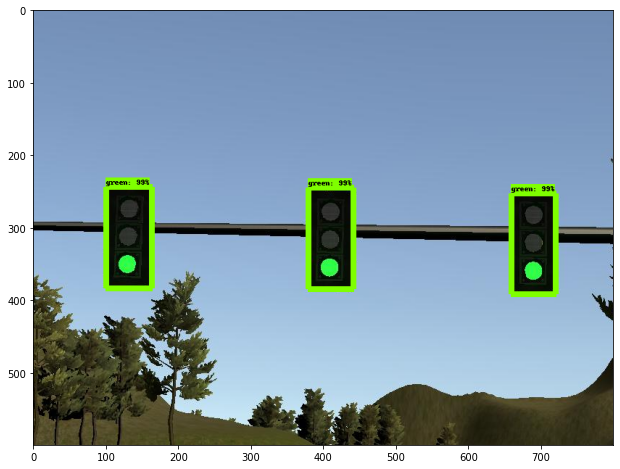

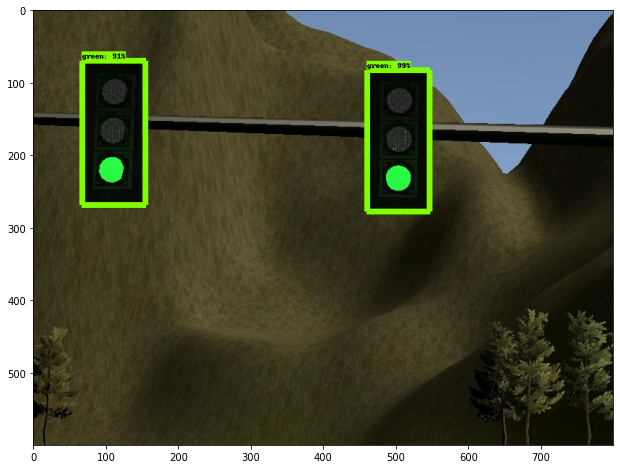

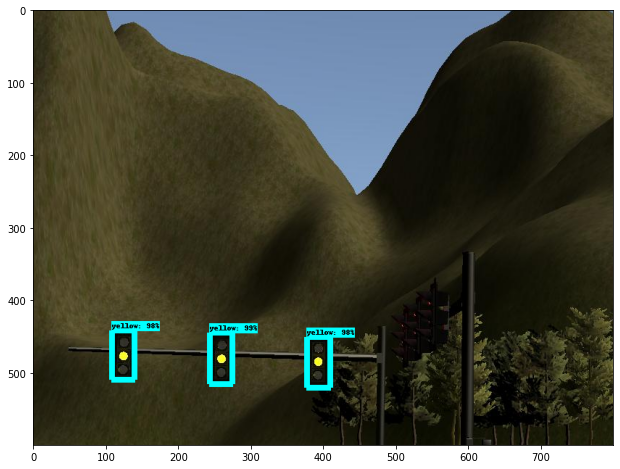

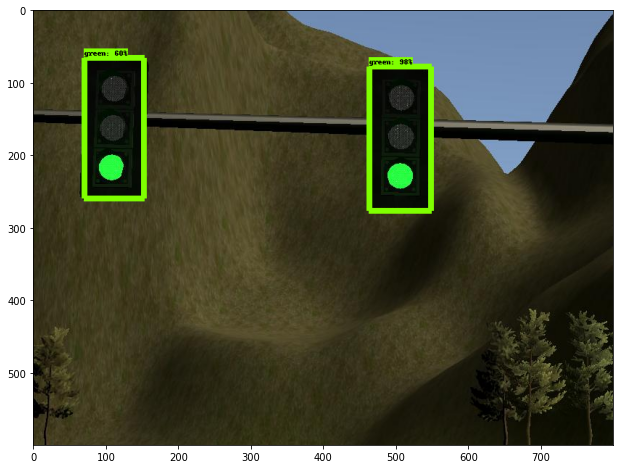

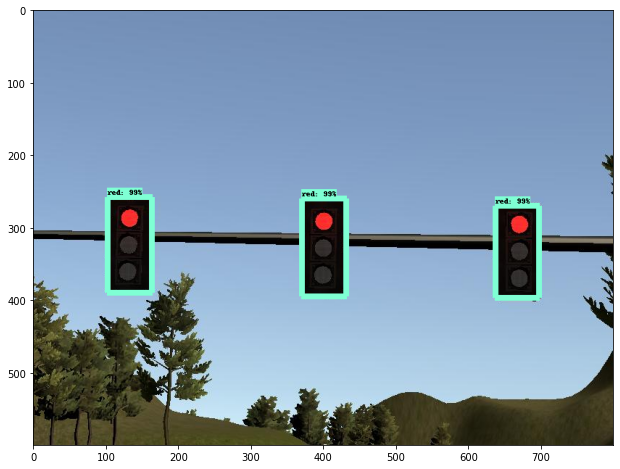

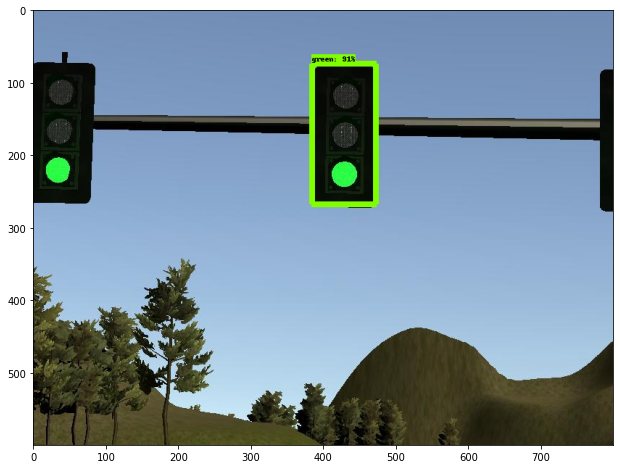

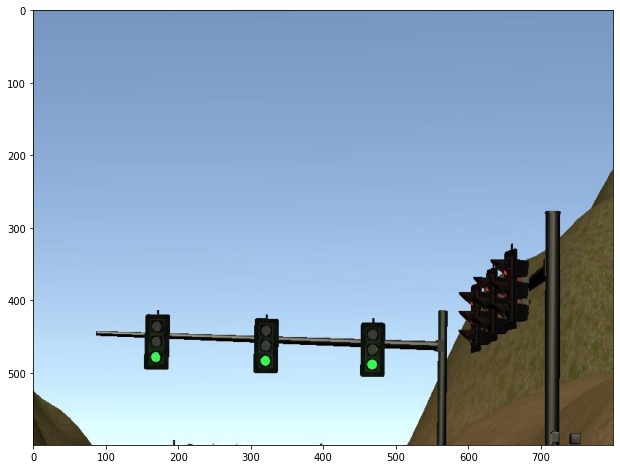

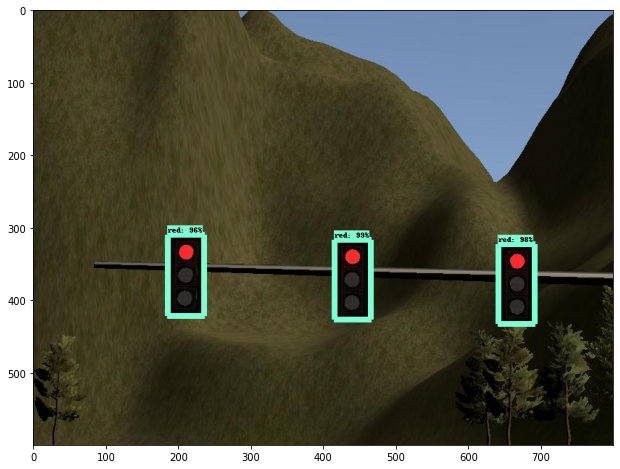

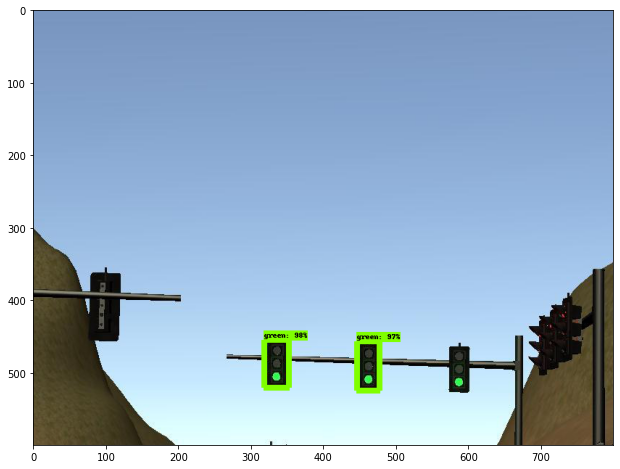

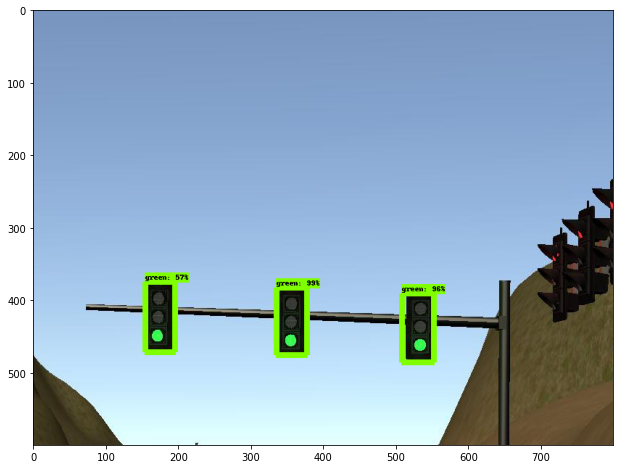

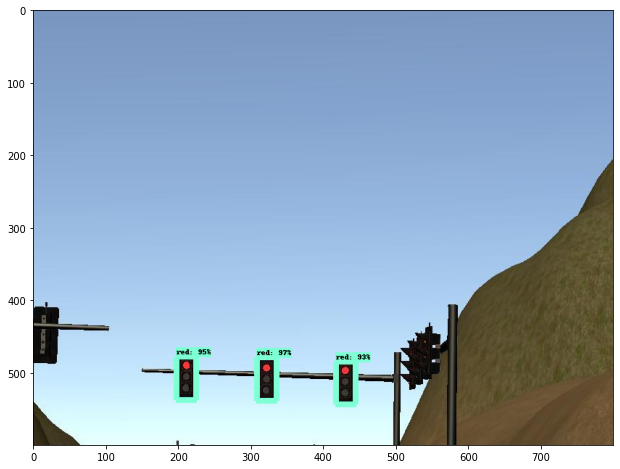

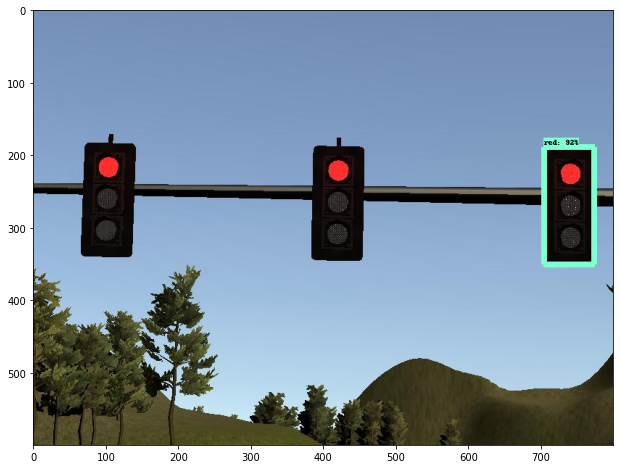

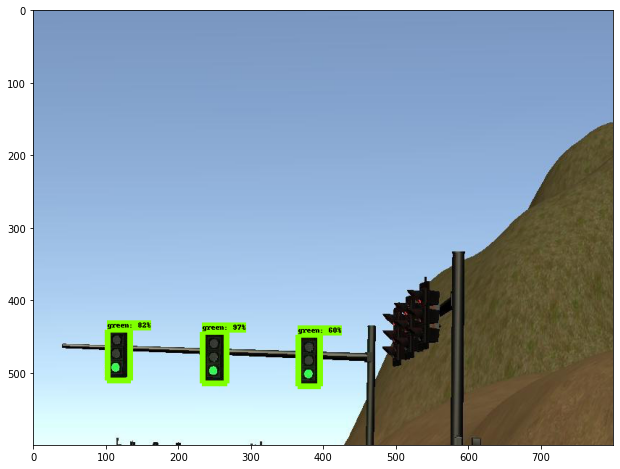

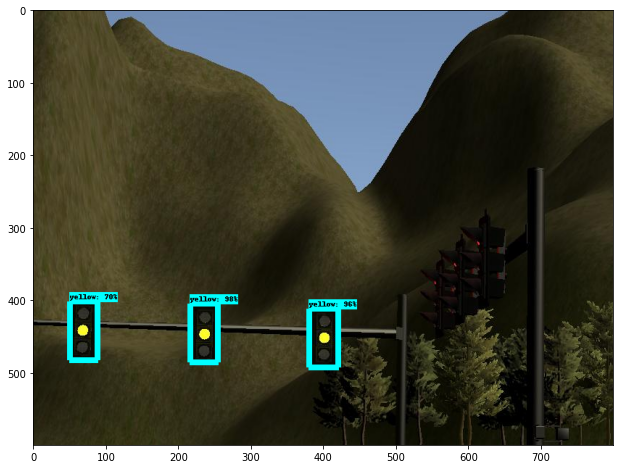

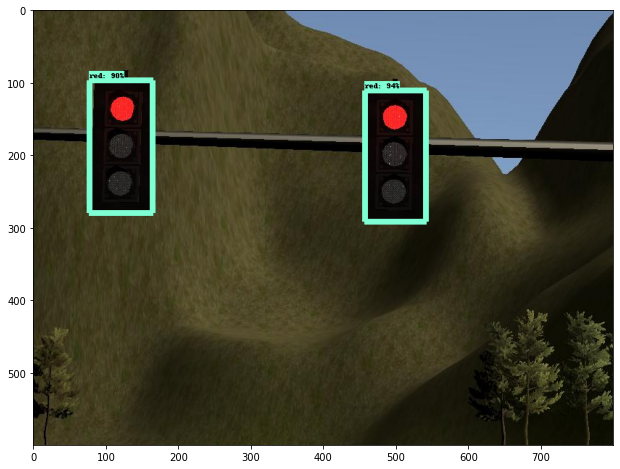

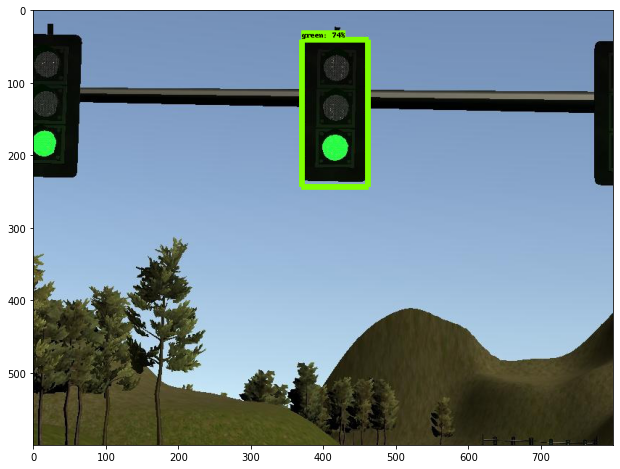

In [47]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

num_classes = 3

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)